<h1>Generación de muestras mediante GANS</h1>

Las redes neuronales generativas (RNG) son un tipo de modelo de inteligencia artificial que aprende a generar datos nuevos y originales que tienen características similares a los datos con los que fueron entrenadas. Estas redes son particularmente útiles en la generación de imágenes, texto, música y otros tipos de datos creativos.

En este caso la red neronal va a generar muestras, con valores de expresión genica similares o perfectamente confundibles con las muestras ejemplo, que son las que poseemos. 

In [5]:
#Creamos la función para crear datos a partir de un generador y un discriminador

def generar_muestras(reference, num_muestras, row_names, export=False, graph=False):

    #Importamos librerias
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    import numpy as np
    import pandas as pd

    # Creación del generador
    generador = Sequential([
        Dense(512, activation='relu', input_shape=(reference.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(reference.shape[1], activation='linear')
    ])

    # Compilar el modelo del generador
    generador.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenamiento del generador
    generador.fit(reference, reference, epochs=50, batch_size=32)

    # Normalización de las nuevas muestras
    media_originales = np.mean(reference, axis=0)
    desviacion_estandar_originales = np.std(reference, axis=0)

    minimos=np.min(reference, axis=0)
    maximos=np.max(reference, axis=0)
    

    muestras_generadas = []

    # Definir el rango de aleatoriedad
    nuevas_muestras = generador.predict(np.random.randn(num_muestras, reference.shape[1]))


    muestras_generadas = []

    # Generar muestras con variaciones aleatorias alrededor de la media original
    for i in range(nuevas_muestras.shape[0]):
        # Generar números aleatorios para cada dimensión basados en la desviación estándar original
        variacion_aleatoria = np.random.normal(0, desviacion_estandar_originales, size=media_originales.shape)
        # Sumar los valores aleatorios a la media original para generar una nueva muestra
        nueva_muestra = media_originales + variacion_aleatoria
        # Asegurarse de que los valores estén dentro del rango original
        nueva_muestra = round(np.clip(nueva_muestra, minimos, maximos))
        # Agregar la nueva muestra al array
        muestras_generadas.append(list(nueva_muestra))

    muestras_generadas = np.array(muestras_generadas)


    datos_nuevos_reference = np.vstack([reference, muestras_generadas])
    df_nuevos_reference = pd.DataFrame(datos_nuevos_reference)
    nombres_reference = reference.index.tolist()
    nuevos_nombres = nombres_reference + [f'{row_names}{i+1}' for i in range(len(nombres_reference), len(df_nuevos_reference.index.tolist()))]
    df_nuevos_reference.index = nuevos_nombres
    df_nuevos_reference.columns = reference.columns.tolist()

    # Creación del discriminador
    discriminador = Sequential([
        Dense(512, activation='relu', input_shape=(reference.shape[1],)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Salida binaria (0 o 1)
    ])

    # Compilar el modelo del discriminador
    discriminador.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    # Entrenamiento del discriminador con las muestras reales
    etiquetas_reales = np.ones((reference.shape[0], 1))
    discriminador.fit(reference, etiquetas_reales, epochs=50, batch_size=32)

    # Predicciones del discriminador sobre las muestras generadas
    etiquetas_generadas = discriminador.predict(df_nuevos_reference)

    # Filtrado de muestras generadas por el discriminador
    indices_filtrados = np.where(etiquetas_generadas >= 0.5)[0]
    df_nuevos_reference_filtrado = df_nuevos_reference.iloc[indices_filtrados]

    #Creacion del grafico
    if graph == True:
        import matplotlib.pyplot as plt
        import networkx as nx
        
        # Crear un gráfico dirigido
        G = nx.DiGraph()
        
        # Agregar nodos (capas) a la red
        for i in range(len(generador.layers)):
            layer_name = 'Layer {}'.format(i)
            G.add_node(layer_name)
        
        # Agregar bordes (conexiones entre capas) a la red
        for i in range(len(generador.layers) - 1):
            G.add_edge('Layer {}'.format(i), 'Layer {}'.format(i+1))
        
        # Dibujar la red
        plt.figure(figsize=(10, 5))
        pos = nx.spring_layout(G)  # Posiciones de los nodos
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
        plt.title('Arquitectura de la Red Neuronal')
        plt.show()
    
    generador.summary()
    discriminador.summary()
        

    
    if export == True:
        import pyreadr as pr
        pr.write_rdata("Matriz_redes_neuronales_{}.RData".format(row_names), df_nuevos_reference_filtrado)
        return df_nuevos_reference_filtrado
    else:
        return df_nuevos_reference_filtrado



c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 77881.6328
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 77663.2422
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 77568.6797
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 77319.7734
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 77216.9766
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 77096.3516
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - loss: 77033.1875
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 76923.6328
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 76905.7266
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 76685.6953
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 76472.1094
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 76441.0703
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 75960.0156
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 76111.9922
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 153.1899
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3333 - loss: 387.1216
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6667 - loss: 115.4094
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

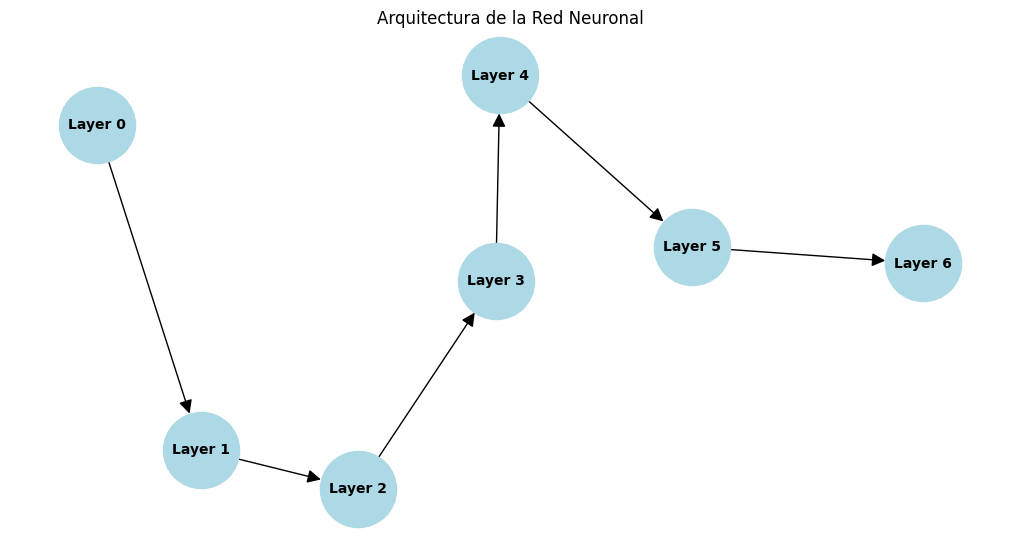

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │    37,996,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 74211)          │     9,573,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,201,963 (546.27 MB)

 Trainable params: 47,733,987 (182.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,467,976 (364.18 MB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │    37,996,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,482,693 (436.72 MB)

 Trainable params: 38,160,897 (145.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,321,796 (291.14 MB)

In [6]:
#Una vez creada la función la usamos para nuestros datos 
import pandas as pd
datos = pd.read_table('counts_totales.txt')
df_traspuesto = datos.transpose()
infectados = df_traspuesto.iloc[[0,1,2]]
sanos=df_traspuesto.iloc[[3,4,5]]

datos_generados_infectados=generar_muestras(infectados, 40,'infectados', export=True, graph=True)


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 44242.3242
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 44159.0039
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 44107.0039
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 44004.7969
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 44012.1367
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 43827.2305
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 43804.7344
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 43740.7148
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 43690.7617
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 43497.3711
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 43474.6562
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 43290.1250
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 43400.7617
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 43092.6719
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.0000e+00 - loss: 238.8408
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━

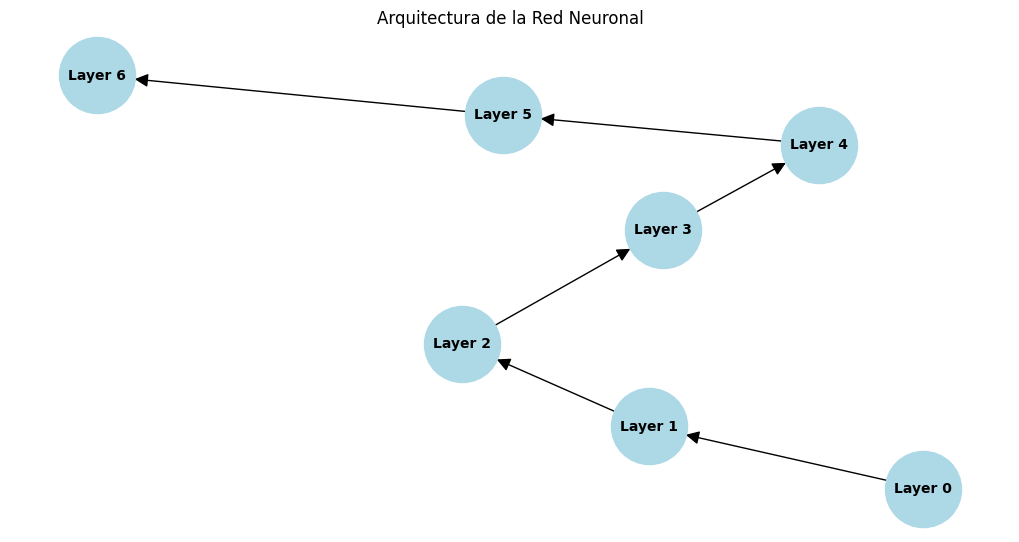

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │    37,996,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 74211)          │     9,573,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,201,963 (546.27 MB)

 Trainable params: 47,733,987 (182.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 95,467,976 (364.18 MB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 512)            │    37,996,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,482,693 (436.72 MB)

 Trainable params: 38,160,897 (145.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,321,796 (291.14 MB)

In [7]:
datos_generados_sanos=generar_muestras(sanos, 40,'sanos', export=True, graph=True)